In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [2]:
mnist= fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
## Lets seperate the target and independent features
# each image is 28x28 pixels
X,y= mnist['data'],mnist['target']
print(X.shape,y.shape)

(70000, 784) (70000,)


In [7]:
#each feature simply represents one pixel’s intensity, from 0
#(white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to
#do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using
import matplotlib as mpl
import matplotlib.pyplot as plt

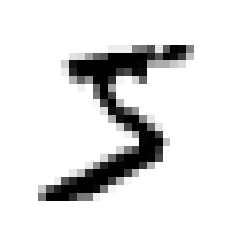

In [8]:
some_dig=X[0]
some_dig_img= some_dig.reshape(28,28)

plt.imshow(some_dig_img, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
## Looks like 5 it is exactly what the label is telling us as well 
y[0]

'5'

In [4]:
## Since the output labels are string datatypes we need to convert them to integer
y= y.astype(np.uint8)

In [5]:
## The dataset was already split into train and test data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
## Lets start with a binary classifier 
# for simplicity sake we will pick only one digit '5'
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [9]:
## First we will apply the Stochastic Gradient Descent classifier
#The SGDClassifier relies on randomness during training (hence the name “stochastic”).
from sklearn.linear_model import SGDClassifier

sgdclf= SGDClassifier(random_state=42)
sgdclf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
## apply it to detect images of number 5
# The classifier guesses that this image represents a 5 (True)
sgdclf.predict([some_dig])

array([ True])

### Precision-Recall trade-off

In [13]:
## We will use cross_validation to get a reliable model
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,random_state=42)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [14]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf= clone(sgdclf)
    X_train_folds= X_train[train_index]
    y_train_folds= y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgdclf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
## Now for making a generalized model we need to predict recognition of every digit
# So we are using cross_val_predict to predict the values for each test fold
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgdclf,X_train,y_train_5,cv=3)

In [17]:
## Use Confusion Matrix for checking the prediction accuracy
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_pred,y_train_5)

array([[53892,  1891],
       [  687,  3530]])

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
#Instead of calling the classifier’spredict() method, you can call its decision_function() method,
#which returns ascore for each instance, and then make predictions based on those scores using,
#any threshold you want

y_scores = sgdclf.decision_function([some_dig])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)


In [24]:
#This confirms that raising the threshold decreases recall.
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [12]:
## To find the right threshold,first need to get the scores of all instances in the training set
y_scores = cross_val_predict(sgdclf, X_train, y_train_5, cv=3,
method="decision_function")

In [26]:
#Now with these scores you can compute precision and recall for all possible thresholds
#using the precision_recall_curve() function:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

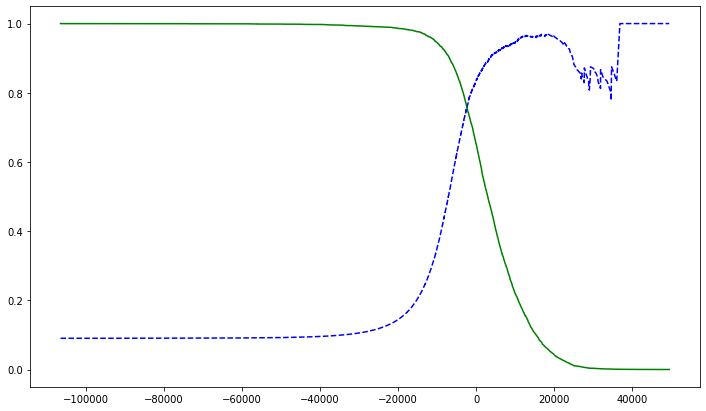

In [30]:
## Here we can see the precision-recall tradeoff and how Threshold value acts as a catalyst
plt.figure(figsize=(12,7))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## ROC Curve

In [13]:
from sklearn.metrics import roc_curve
# before plotting the roc curve we need to compute the TPR and FPR for variuous thresholds

fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

In [17]:
def plot_roc(fpr,tpr,label= None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1],[0,1],'k--')
    

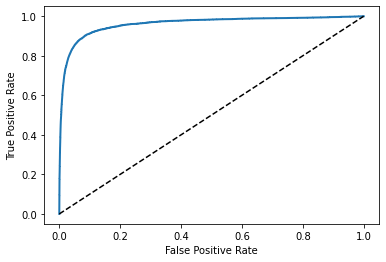

In [18]:
plot_roc(fpr,tpr)
plt.show()

In [19]:
#One way to compare classifiers is to measure the area under the curve (AUC).
##A perfectclassifier will have a ROC AUC equal to 1, whereas a purely random classifier will
#have a ROC AUC equal to 0.5.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest= cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [25]:
y_prob_forest.shape

(60000, 2)

In [22]:
y_scores_forest = y_prob_forest[:, 1]
fpr_forest,tpr_forests,thresholds_forest= roc_curve(y_train_5,y_scores_forest)

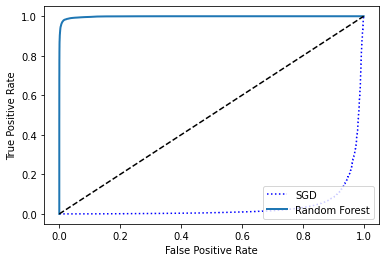

In [28]:
plt.plot(tpr,fpr,'b:',label="SGD")
plot_roc(fpr_forest,tpr_forests,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [29]:
## We can clearly see that Random Forest performed far too better than SGD Classifier
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multi-Class Classification

In [10]:
from sklearn.linear_model import SGDClassifier

In [30]:
## The classification done is wrong instead of 5 it was classified as 3,
# Here thew whole y_train data is taken
sgdclf.fit(X_train, y_train)
sgdclf.predict([some_dig])

array([3], dtype=uint8)

In [31]:
some_dig_scores=sgdclf.decision_function([some_dig])
some_dig_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [32]:
np.argmax(some_dig_scores)

3

In [ ]:
sgdclf.classes_

In [9]:
from sklearn.multiclass import OneVsOneClassifier

In [11]:
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_dig])

array([5], dtype=uint8)

In [12]:
len(ovo_clf.estimators_)

45

In [14]:
## Lets see how RF classifier works
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_dig])

array([5], dtype=uint8)

In [15]:
## Below are the probabilities the classifier assigned to each class
forest_clf.predict_proba([some_dig])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [16]:
sgdclf=SGDClassifier(random_state=42)

In [17]:
## Lets check SGD classifiers accuracy with cross_validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgdclf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [18]:
## RandomForest Classifier gave us much better accuracy
cross_val_score(forest_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

In [21]:
## In order to improve the accuracy of SGDClassifier we have to scale the inputs
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgdclf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [20]:
from sklearn.metrics import confusion_matrix

In [25]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgdclf, X_train_scaled, y_train, cv=3)

In [26]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

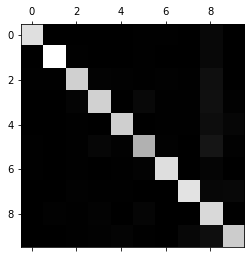

In [27]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [28]:
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums

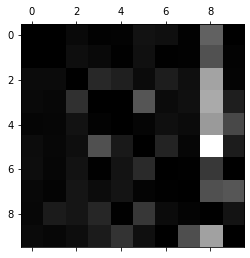

In [30]:
#Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:
##The column for class 8 is quite bright, which tells you that many images get misclassified as 8s.
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [11]:
#This code creates a y_multilabel array containing two target labels for each digit
#image: the first indicates whether or not the digit is large (7, 8, or 9) and the second
#indicates whether or not it is odd.

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [13]:
#And it gets it right! The digit 5 is indeed not large (False) and odd (True).
knn_clf.predict([some_dig])

array([[False,  True]])

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.976410265560605